In [17]:
import commot as ct
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
adata_2 = sc.datasets.visium_sge(sample_id='V1_Mouse_Brain_Sagittal_Posterior')
adata_2

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [19]:
adata = sc.read_h5ad('seurat_ST1.h5ad')
adata

AnnData object with n_obs × n_vars = 4095 × 36601
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial'
    var: 'features'

In [20]:
obs = pd.read_csv('data/seurat_ST1_obs.csv', sep = ' ')
obs.columns = ['in_tissue', 'array_row', 'array_col']


In [21]:
adata.obs = obs.copy()

In [22]:
adata.uns = adata_2.uns.copy()

In [23]:
obsm = pd.read_csv('data/seurat_ST1_obsm.csv', sep = ' ')
obsm = np.array(obsm)
obsm_list = list()
for i in range(len(obsm)):
    obsm_list.append([obsm[i][1], obsm[i][0]])
np.array(obsm_list)

adata.obsm['spatial'] = np.array(obsm_list)

In [24]:
imageR = np.array(pd.read_csv('data/seurat_ST1_imageR.csv', sep = ' '))
imageG = np.array(pd.read_csv('data/seurat_ST1_imageG.csv', sep = ' '))
imageB = np.array(pd.read_csv('data/seurat_ST1_imageB.csv', sep = ' '))

image_list3D = list()
for i in range(len(np.array(imageR))):
    image_list2D = list()
    for j in range(len(np.array(imageR)[1])):
        image_list2D.append([imageR[i][j], imageG[i][j], imageB[i][j]])
        
    image_list3D.append(image_list2D)
hires = np.array(image_list3D)

adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Posterior']['images']['hires'] = hires.copy()

In [25]:
spot_diameter = pd.read_csv('data/seurat_ST1_spot_diameter.csv', sep = ' ')
hires_scalef = pd.read_csv('data/seurat_ST1_hires_scalef.csv', sep = ' ')
fiducial_diameter = pd.read_csv('data/seurat_ST1_fiducial_diameter.csv', sep = ' ')

adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Posterior']['scalefactors']['spot_diameter_fullres'] = 150
adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Posterior']['scalefactors']['tissue_hires_scalef'] = hires_scalef['x'][1]
adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Posterior']['scalefactors']['fiducial_diameter_fullres'] = fiducial_diameter['x'][1]


In [26]:
#adata.write_h5ad('seurat_ST1_scanpy.h5ad') #Does this work for you???

In [27]:
adata

AnnData object with n_obs × n_vars = 4095 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'features'
    uns: 'spatial'
    obsm: 'spatial'

In [28]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

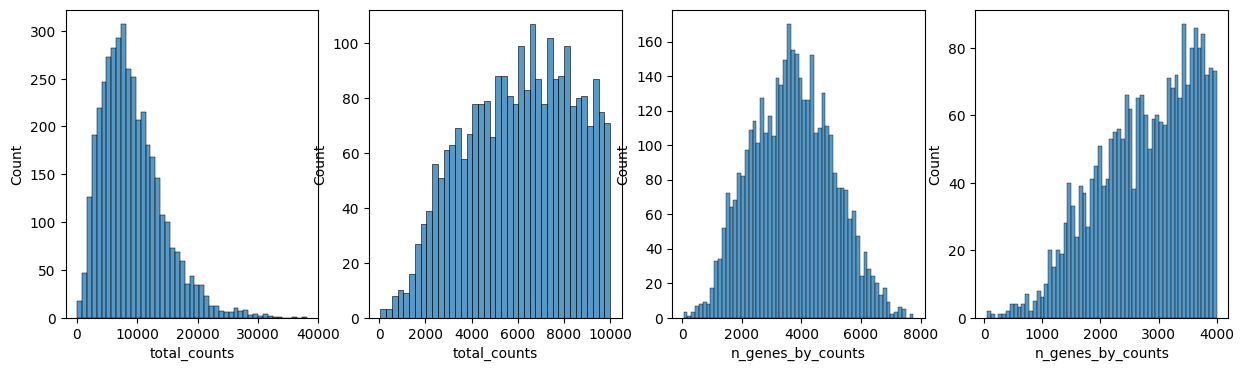

In [29]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [30]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

#cells after MT filter: 3226


In [31]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [32]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, key_added="clusters", directed=False, n_iterations=2
)

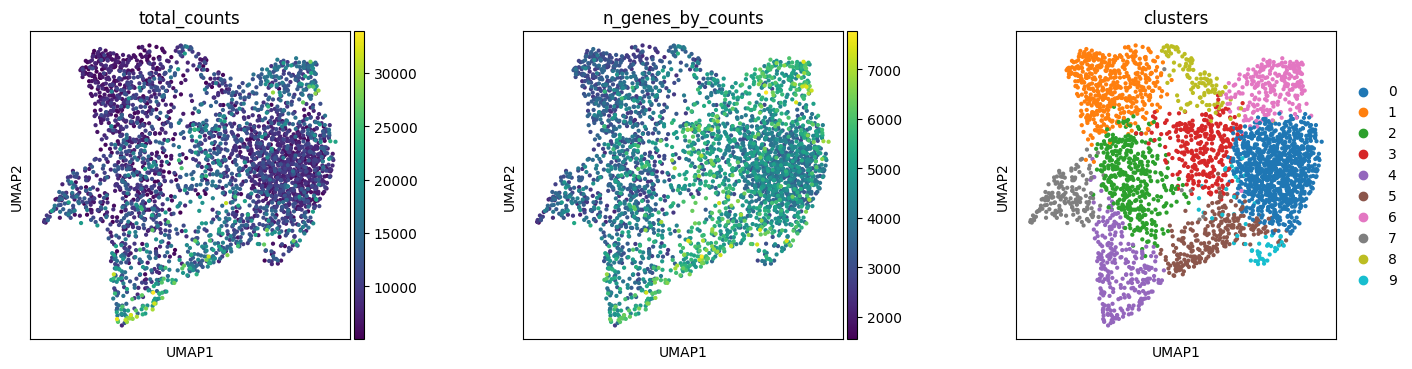

In [33]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

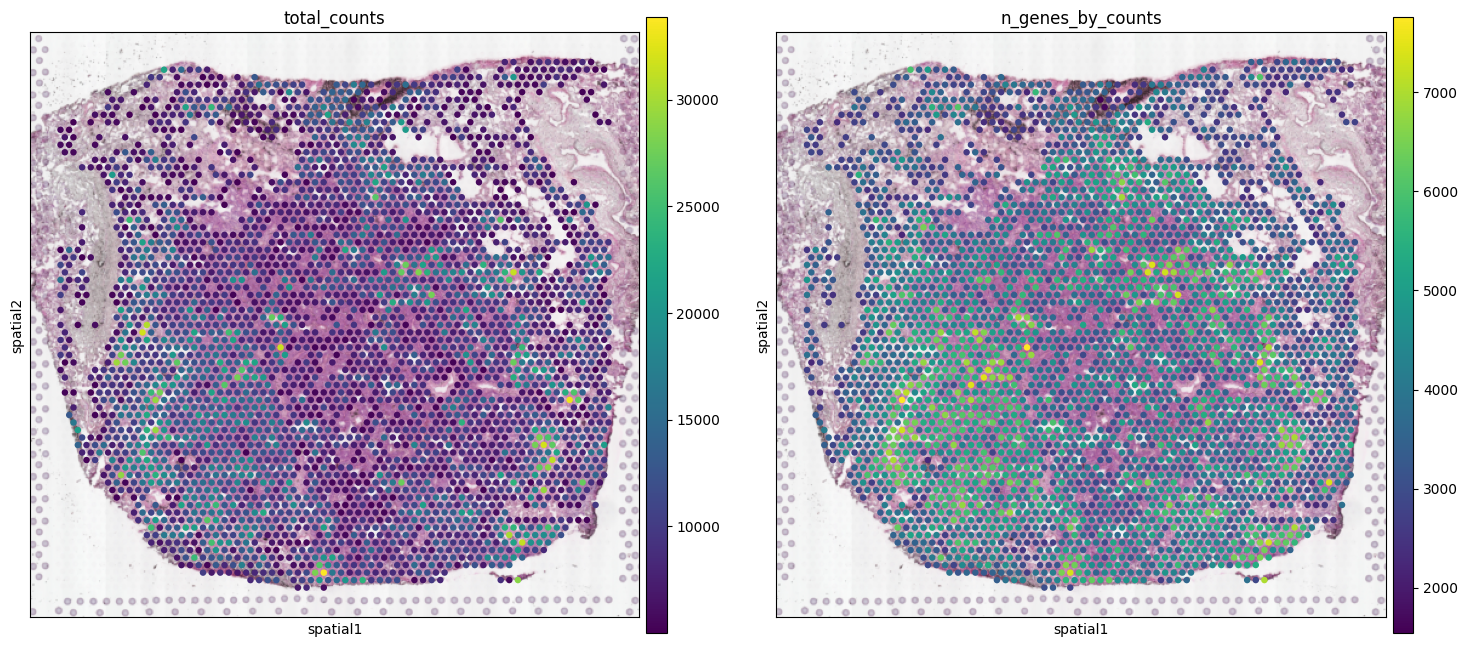

In [34]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

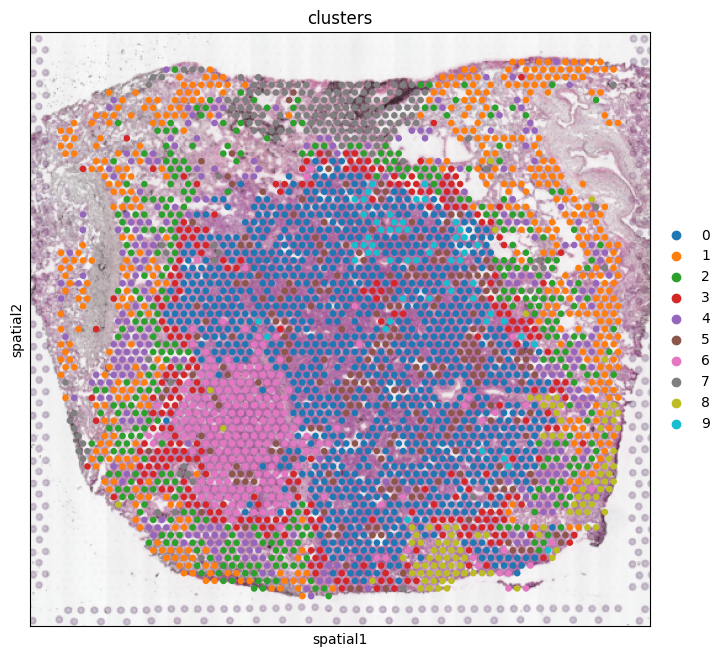

In [35]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1)

In [30]:
df_cellchat = ct.pp.ligand_receptor_database(species='human', signaling_type='Secreted Signaling', database='CellChat')
print(df_cellchat.shape)

(1199, 4)


In [31]:
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata, min_cell_pct=0.05)
print(df_cellchat_filtered.shape)

(236, 4)


In [32]:
print(df_cellchat_filtered.head())


       0                    1     2                   3
0  TGFB1        TGFBR1_TGFBR2  TGFb  Secreted Signaling
1  TGFB3        TGFBR1_TGFBR2  TGFb  Secreted Signaling
2  TGFB1        ACVR1B_TGFBR2  TGFb  Secreted Signaling
3  TGFB3        ACVR1B_TGFBR2  TGFb  Secreted Signaling
4  TGFB1  ACVR1_TGFBR1_TGFBR2  TGFb  Secreted Signaling


In [34]:
ct.tl.spatial_communication(adata,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)

In [84]:
adata.obsm['commot-cellchat-sum-sender']

s-CCL3L1-CCR1  s-CTF1-LIFR_IL6ST  s-SPP1-ITGA5_ITGB1   
AAACAAGTATCTCCCA-1       0.000000                0.0            0.139430  \
AAACACCAATAACTGC-1       0.000000                0.0            0.000000   
AAACAGGGTCTATATT-1       0.000000                0.0            0.083265   
AAACAGTGTTCCTGGG-1       0.000000                0.0            0.019990   
AAACATTTCCCGGATT-1       0.304111                0.0            0.160862   
...                           ...                ...                 ...   
TTGTTCAGTGTGCTAC-1       0.000000                0.0            0.019669   
TTGTTGTGTGTCAAGA-1       0.000000                0.0            0.000000   
TTGTTTCACATCCAGG-1       0.000000                0.0            0.000000   
TTGTTTCCATACAACT-1       0.000000                0.0            0.661230   
TTGTTTGTATTACACG-1       0.378719                0.0            0.000000   

                    s-SPP1-ITGAV_ITGB6  s-SPP1-CD44  s-SPP1-ITGAV_ITGB1   
AAACAAGTATCTCCCA-1            0.002351     0.414998            0.457136  \
AAACACCAATAACTGC-1            0.000000     0.000000            0.000000   
AAACAGGGTCTATATT-1            0.016756     2.013945            0.052720   
AAACAGTGTTCCTGGG-1            0.522744     1.698939            0.533150   
AAACATTTCCCGGATT-1            0.122633     0.483061            0.373435   
...                                ...          ...                 ...   
TTGTTCAGTGTGCTAC-1            0.017363     1.162901            0.067744   
TTGTTGTGTGTCAAGA-1            0.000000     0.000000            0.000000   
TTGTTTCACATCCAGG-1            0.000000     0.000000            0.000000   
TTGTTTCCATACAACT-1            0.068980     1.743267            0.086029   
TTGTTTGTATTACACG-1            0.000000     0.000000            0.000000   

                    s-SPP1-ITGA8_ITGB1  s-SPP1-ITGA4_ITGB1   
AAACAAGTATCTCCCA-1            0.000335            0.004580  \
AAACACCAATAACTGC-1            0.000000            0.000000   
AAACAGGGTCTATATT-1            0.015790            0.070609   
AAACAGTGTTCCTGGG-1            0.019457            0.049360   
AAACATTTCCCGGATT-1            0.000000            0.121834   
...                                ...                 ...   
TTGTTCAGTGTGCTAC-1            0.252673            0.037704   
TTGTTGTGTGTCAAGA-1            0.000000            0.000000   
TTGTTTCACATCCAGG-1            0.000000            0.000000   
TTGTTTCCATACAACT-1            0.001297            0.073233   
TTGTTTGTATTACACG-1            0.000000            0.000000   

                    s-SPP1-ITGA9_ITGB1  s-SPP1-ITGAV_ITGB5  ...    s-SPP1   
AAACAAGTATCTCCCA-1            0.002284            0.276991  ...  1.298105  \
AAACACCAATAACTGC-1            0.000000            0.000000  ...  0.000000   
AAACAGGGTCTATATT-1            0.010466            0.032168  ...  2.295718   
AAACAGTGTTCCTGGG-1            0.200820            0.366888  ...  3.411348   
AAACATTTCCCGGATT-1            0.342420            0.168306  ...  1.772551   
...                                ...                 ...  ...       ...   
TTGTTCAGTGTGCTAC-1            0.005958            0.039692  ...  1.603703   
TTGTTGTGTGTCAAGA-1            0.000000            0.000000  ...  0.000000   
TTGTTTCACATCCAGG-1            0.000000            0.000000  ...  0.000000   
TTGTTTCCATACAACT-1            0.466595            0.064005  ...  3.164636   
TTGTTTGTATTACACG-1            0.000000            0.000000  ...  0.000000   

                      s-TGFb  s-TNF   s-TWEAK   s-UGRP1    s-VEGF    s-VEGI   
AAACAAGTATCTCCCA-1  0.654704    0.0  0.000000  0.991333  0.631816  0.588754  \
AAACACCAATAACTGC-1  0.775595    0.0  1.174592  0.316855  0.717027  0.000000   
AAACAGGGTCTATATT-1  0.000000    0.0  0.481625  0.499775  0.313585  0.000000   
AAACAGTGTTCCTGGG-1  0.851210    0.0  0.000000  0.000000  1.033629  0.000000   
AAACATTTCCCGGATT-1  0.937672    0.0  0.000000  0.000000  0.053113  0.000000   
...                      ...    ...       ...       ...       

<Axes: >

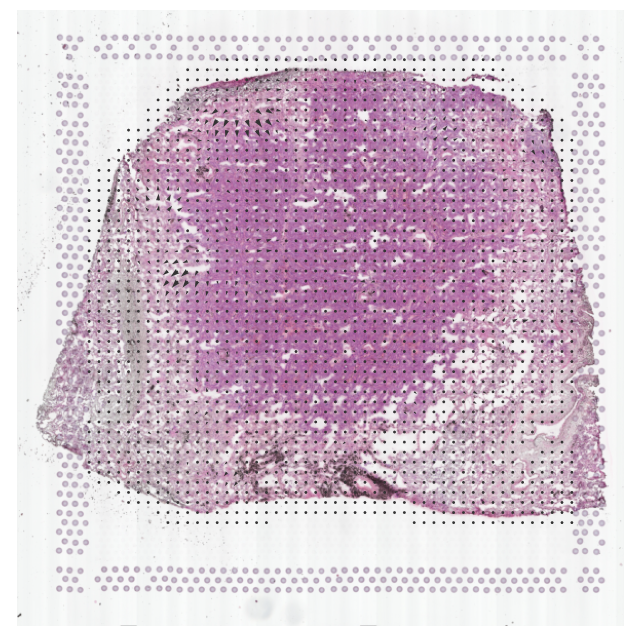

In [87]:
ct.tl.communication_direction(adata, database_name='cellchat', pathway_name='SPP1', k=5)
ct.pl.plot_cell_communication(adata, database_name='cellchat', pathway_name='SPP1', plot_method='grid', background_legend=True,
    scale=0.00003, ndsize=8, grid_density=1, summary='sender', background='image', clustering='leiden', cmap='Alphabet',
    normalize_v = True, normalize_v_quantile=0.995)

s-CCL3L1-CCR1  s-CTF1-LIFR_IL6ST  s-SPP1-ITGA5_ITGB1   
AAACAAGTATCTCCCA-1       0.000000                0.0            0.139430  \
AAACACCAATAACTGC-1       0.000000                0.0            0.000000   
AAACAGGGTCTATATT-1       0.000000                0.0            0.083265   
AAACAGTGTTCCTGGG-1       0.000000                0.0            0.019990   
AAACATTTCCCGGATT-1       0.304111                0.0            0.160862   
...                           ...                ...                 ...   
TTGTTCAGTGTGCTAC-1       0.000000                0.0            0.019669   
TTGTTGTGTGTCAAGA-1       0.000000                0.0            0.000000   
TTGTTTCACATCCAGG-1       0.000000                0.0            0.000000   
TTGTTTCCATACAACT-1       0.000000                0.0            0.661230   
TTGTTTGTATTACACG-1       0.378719                0.0            0.000000   

                    s-SPP1-ITGAV_ITGB6  s-SPP1-CD44  s-SPP1-ITGAV_ITGB1   
AAACAAGTATCTCCCA-1            0.002351     0.414998            0.457136  \
AAACACCAATAACTGC-1            0.000000     0.000000            0.000000   
AAACAGGGTCTATATT-1            0.016756     2.013945            0.052720   
AAACAGTGTTCCTGGG-1            0.522744     1.698939            0.533150   
AAACATTTCCCGGATT-1            0.122633     0.483061            0.373435   
...                                ...          ...                 ...   
TTGTTCAGTGTGCTAC-1            0.017363     1.162901            0.067744   
TTGTTGTGTGTCAAGA-1            0.000000     0.000000            0.000000   
TTGTTTCACATCCAGG-1            0.000000     0.000000            0.000000   
TTGTTTCCATACAACT-1            0.068980     1.743267            0.086029   
TTGTTTGTATTACACG-1            0.000000     0.000000            0.000000   

                    s-SPP1-ITGA8_ITGB1  s-SPP1-ITGA4_ITGB1   
AAACAAGTATCTCCCA-1            0.000335            0.004580  \
AAACACCAATAACTGC-1            0.000000            0.000000   
AAACAGGGTCTATATT-1            0.015790            0.070609   
AAACAGTGTTCCTGGG-1            0.019457            0.049360   
AAACATTTCCCGGATT-1            0.000000            0.121834   
...                                ...                 ...   
TTGTTCAGTGTGCTAC-1            0.252673            0.037704   
TTGTTGTGTGTCAAGA-1            0.000000            0.000000   
TTGTTTCACATCCAGG-1            0.000000            0.000000   
TTGTTTCCATACAACT-1            0.001297            0.073233   
TTGTTTGTATTACACG-1            0.000000            0.000000   

                    s-SPP1-ITGA9_ITGB1  s-SPP1-ITGAV_ITGB5  ...    s-SPP1   
AAACAAGTATCTCCCA-1            0.002284            0.276991  ...  1.298105  \
AAACACCAATAACTGC-1            0.000000            0.000000  ...  0.000000   
AAACAGGGTCTATATT-1            0.010466            0.032168  ...  2.295718   
AAACAGTGTTCCTGGG-1            0.200820            0.366888  ...  3.411348   
AAACATTTCCCGGATT-1            0.342420            0.168306  ...  1.772551   
...                                ...                 ...  ...       ...   
TTGTTCAGTGTGCTAC-1            0.005958            0.039692  ...  1.603703   
TTGTTGTGTGTCAAGA-1            0.000000            0.000000  ...  0.000000   
TTGTTTCACATCCAGG-1            0.000000            0.000000  ...  0.000000   
TTGTTTCCATACAACT-1            0.466595            0.064005  ...  3.164636   
TTGTTTGTATTACACG-1            0.000000            0.000000  ...  0.000000   

                      s-TGFb  s-TNF   s-TWEAK   s-UGRP1    s-VEGF    s-VEGI   
AAACAAGTATCTCCCA-1  0.654704    0.0  0.000000  0.991333  0.631816  0.588754  \
AAACACCAATAACTGC-1  0.775595    0.0  1.174592  0.316855  0.717027  0.000000   
AAACAGGGTCTATATT-1  0.000000    0.0  0.481625  0.499775  0.313585  0.000000   
AAACAGTGTTCCTGGG-1  0.851210    0.0  0.000000  0.000000  1.033629  0.000000   
AAACATTTCCCGGATT-1  0.937672    0.0  0.000000  0.000000  0.053113  0.000000   
...                      ...    ...       ...       ...       

Text(0.5, 1.0, 'Receiver')

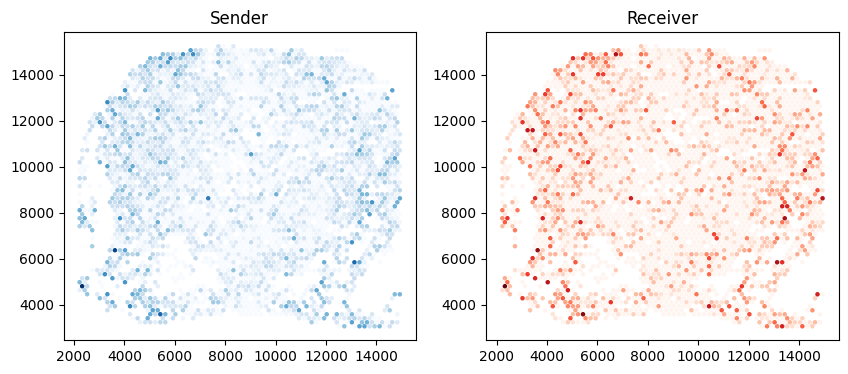

In [83]:
pts = adata.obsm['spatial']
s = adata.obsm['commot-cellchat-sum-sender']['s-VEGF']
r = adata.obsm['commot-cellchat-sum-receiver']['r-VEGF']
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(pts[:,0], pts[:,1], c=s, s=5, cmap='Blues')
ax[0].set_title('Sender')
ax[1].scatter(pts[:,0], pts[:,1], c=r, s=5, cmap='Reds')
ax[1].set_title('Receiver')

In [49]:
adata.obs

in_tissue  array_row  array_col  n_genes_by_counts   
AAACAAGTATCTCCCA-1          1         50        102               4724  \
AAACACCAATAACTGC-1          1         59         19               6906   
AAACAGGGTCTATATT-1          1         47         13               6174   
AAACAGTGTTCCTGGG-1          1         73         43               4583   
AAACATTTCCCGGATT-1          1         61         97               4856   
...                       ...        ...        ...                ...   
TTGTTCAGTGTGCTAC-1          1         24         64               3651   
TTGTTGTGTGTCAAGA-1          1         31         77               3764   
TTGTTTCACATCCAGG-1          1         58         42               3777   
TTGTTTCCATACAACT-1          1         45         27               5169   
TTGTTTGTATTACACG-1          1         73         41               3575   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts   
AAACAAGTATCTCCCA-1                 8.460623       11347.0            9.336797  \
AAACACCAATAACTGC-1                 8.840291       25786.0           10.157626   
AAACAGGGTCTATATT-1                 8.728264       29657.0           10.297487   
AAACAGTGTTCCTGGG-1                 8.430327       12754.0            9.453679   
AAACATTTCCCGGATT-1                 8.488176       11314.0            9.333885   
...                                     ...           ...                 ...   
TTGTTCAGTGTGCTAC-1                 8.203030        6871.0            8.835210   
TTGTTGTGTGTCAAGA-1                 8.233503        7331.0            8.900004   
TTGTTTCACATCCAGG-1                 8.236950        7584.0            8.933928   
TTGTTTCCATACAACT-1                 8.550628       16641.0            9.719685   
TTGTTTGTATTACACG-1                 8.182000        8675.0            9.068316   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
AAACAAGTATCTCCCA-1                   15.722217                    22.023442  \
AAACACCAATAACTGC-1                   22.190336                    29.310479   
AAACAGGGTCTATATT-1                   31.291095                    39.012712   
AAACAGTGTTCCTGGG-1                   22.824212                    30.719774   
AAACATTTCCCGGATT-1                   19.869189                    25.578929   
...                                        ...                          ...   
TTGTTCAGTGTGCTAC-1                   14.102751                    20.477369   
TTGTTGTGTGTCAAGA-1                   15.059337                    21.647797   
TTGTTTCACATCCAGG-1                   14.939346                    21.782700   
TTGTTTCCATACAACT-1                   27.876930                    34.955832   
TTGTTTGTATTACACG-1                   22.639769                    30.997118   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
AAACAAGTATCTCCCA-1                    30.413325                    44.734291  \
AAACACCAATAACTGC-1                    37.896533                    50.135733   
AAACAGGGTCTATATT-1                    48.619213                    60.855784   
AAACAGTGTTCCTGGG-1                    39.893367                    52.752078   
AAACATTTCCCGGATT-1                    32.773555                    45.757469   
...                                         ...                          ...   
TTGTTCAGTGTGCTAC-1                    28.598457                    43.458012   
TTGTTGTGTGTCAAGA-1                    29.641249                    44.250443   
TTGTTTCACATCCAGG-1                    30.406118                    44.725738   
TTGTTTCCATACAACT-1                    43.464936                    55.417343   
TTGTTTGTATTACACG-1                    40.564841                    54.305476   

                    total_counts_mt  log1p_total_counts_mt  pct_counts_mt   
AAACAAGTATCTCCCA-1            275.0               5.620401       2.423548  \
AAACACCAATAACTGC-1           1234.0               7.118826       4.785543   
AAACAGGGTCTATATT-

In [50]:
ct.tl.cluster_communication(adata, database_name='cellchat', pathway_name='PSAP', clustering='clusters', n_permutations=100)